# Deep Neural Networks Marathon

print torch info

In [1]:
# torch version and gpu info on pc
import torch

print('torch version',torch.__version__, 'number of gpu',torch.cuda.device_count())
for id in range(torch.cuda.device_count()): print('gpu info', torch.cuda.get_device_properties(id))

torch version 2.1.0+cu121 number of gpu 1
gpu info _CudaDeviceProperties(name='NVIDIA GeForce RTX 3050 4GB Laptop GPU', major=8, minor=6, total_memory=4095MB, multi_processor_count=20)


In [1]:
# torch version and gpu info on workstation
import torch

print('torch version',torch.__version__, 'number of gpu',torch.cuda.device_count())
for id in range(torch.cuda.device_count()): print('gpu info', torch.cuda.get_device_properties(id))


torch version 2.1.0+cu121 number of gpu 1
gpu info _CudaDeviceProperties(name='Quadro RTX 5000', major=7, minor=5, total_memory=16383MB, multi_processor_count=48)


FLOPS and parameters of a model

In [2]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info # pip install ptflops

with torch.cuda.device(0):
  net = models.densenet161()
  macs, params = get_model_complexity_info(net, (3, 224, 224), as_strings=True, backend='pytorch', print_per_layer_stat=False, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       7.85 GMac
Number of parameters:           28.68 M 


### 2D Neural networks

architecture of alexnet style1

In [28]:
# alexnet

import torch
import torch.nn as nn
import torch.nn.functional as F


class AlexNet(nn.Module):# 这行代码定义了一个名为 AlexNet 的 PyTorch 模型类，它继承自 nn.Module 类。nn.Module 是 PyTorch 中所有模型类的基类。
    ##super() 函数用于获取父类的实例。在本例中，父类是 nn.Module。
    ##(AlexNet, self) 是元组，用于指定子类和当前实例。
    ##__init__() 是 Python 中类的构造函数。它在类实例化时被调用，用于初始化类的属性和方法。
    ##self 是 Python 中的自我引用，表示当前类的实例。num_classes 是参数，用于指定模型的类别数。
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__() 
        #卷积层用于提取图像中的特征。
        #该层将输入图像 (3 通道 RGB 图像) 转换为 96 通道特征图。卷积核大小为 11，步长为 4，填充为 2。
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2) 
        ##池化层用于减少特征图的大小。第一个池化层使用 3x3 的最大池化核，步长为 2。 
        ##这意味着它会在输入特征图上移动 2 个像素，并取每个池化核覆盖区域内的最大值。这样可以减少特征图的大小，并保留最重要的信息。
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2) 
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        ##全连接层用于将提取到的特征进行分类。第一个全连接层有 4096 个神经元。这意味着它会将提取到的特征向量投影到一个 4096 维度的空间中。
        ##第二个全连接层也有 4096 个神经元。这意味着它会进一步将特征向量投影到一个 4096 维度的空间中。第三个全连接层有 10 个神经元，对应于 10 个类别。
        self.fc1 = nn.Linear(256 * 6 * 6, 4096) 
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    # forward() 方法是模型的前向传播函数。它用于将输入数据转换为输出数据。
    def forward(self, x):
        x = self.conv1(x)
        ##ReLU 激活函数用于卷积层和全连接层。ReLU 激活函数是一种非线性激活函数，它可以将输入值映射到 0 和正无穷之间。
        ##ReLU 激活函数可以加速模型的收敛速度，并防止梯度消失问题。
        ##F.relu(x) 是 PyTorch 中 F 模块中的一个函数。它是一个函数，可以应用到输入张量中。
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)
        #x = self.conv5(x)
        ##view将张量展平为一维张量,其大小为 (batch_size, channels * height * width)
        ##x.size(0) 表示 x 的第一个维度，即 batch_size。-1 表示 x 的其他维度将被自动计算。
        x = x.view(x.size(0), -1)
        print(x.size())
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [29]:
# test model
model = AlexNet(num_classes=10)
#print(model)
x = torch.randn(2, 3, 224, 224)  # 随机生成一个张量
out = model(x) 

torch.Size([2, 9216])


architecture of alexnet style2

In [45]:
# alexnet, another implemention
import torch
import torch.nn as nn
import torch.nn.functional as F

'''
nn.BatchNorm2d()：批量归一化 (Batch Normalization) 是深度学习中非常常用的归一化函数。
它通过将每个样本的输入归一化到相同的均值和方差来提高模型的稳定性和性能。

nn.GroupNorm()：分组归一化 (Group Normalization) 是批量归一化的一种变体。
它将输入张量分成多个组，并对每个组进行归一化。这使得 GroupNorm 更适合处理具有大量参数的模型。

nn.LayerNorm()：层归一化 (Layer Normalization) 是批量归一化的另一种变体。
它将归一化应用于每个层的输出，而不是每个样本的输入。这使得 LayerNorm 更适合处理具有不同长度输入的模型。

nn.InstanceNorm2d()：实例归一化 (Instance Normalization) 是批量归一化的另一种变体。
它将归一化应用于每个样本中的每个通道。这使得 InstanceNorm 更适合处理具有不同分布的数据。

nn.LazyBatchNorm2d()：惰性批量归一化 (Lazy Batch Normalization) 是批量归一化的一种变体。
它在训练时使用批量归一化，在推理时使用指数移动平均 (EMA) 来计算均值和方差。这使得 LazyBatchNorm2d 在推理时速度更快。

nn.SyncBatchNorm()：同步批量归一化 (Sync Batch Normalization) 是批量归一化的一种变体。
它在多 GPU 训练中使用，将均值和方差同步到所有 GPU 上。这使得 SyncBatchNorm 在多 GPU 训练中更稳定。

nn.LazyInstanceNorm2d()：惰性实例归一化 (Lazy Instance Normalization) 是实例归一化的一种变体。
它在训练时使用实例归一化，在推理时使用指数移动平均 (EMA) 来计算均值和方差。这使得 LazyInstanceNorm2d 在推理时速度更快。
串联网络的几种方法：
nn.Sequential()
nn.ModuleList()：用于将多个神经网络层连接起来，但这些层可以是任意顺序。
nn.ModuleDict()：用于将多个神经网络层连接起来，并将它们分为不同的组。
nn.ModuleList() 和 nn.ModuleDict() 都需要手动连接神经网络层。
'''

class AlexNet1(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet1, self).__init__()
        ##nn.Sequential() 是 PyTorch 中的一个类，用于将多个神经网络层连接起来。它可以看作是一个容器，用于存储神经网络层。
        ##self.features 属性将存储一个 nn.Sequential() 对象，其中包含多个神经网络层。这些神经网络层将被按顺序连接起来，并应用于输入数据。
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            ##当 inplace=False 时，nn.ReLU() 函数将返回一个新的张量，该张量包含了应用 ReLU 激活函数后的结果。
            ##当 inplace=True 时，nn.ReLU() 函数将直接将计算结果保存在 x 中，并返回 x。可以节省内存.
            ##nn.ReLU 是 PyTorch 中 nn 模块中的一个类。它是一个层，可以应用到输入张量中。
            nn.ReLU(inplace=True),
            ##局部响应归一化 (LRN) 的技术来提高模型的泛化能力。在AlexNet中提出。
            ##LRN 通过将相邻像素的值归一化来减少梯度爆炸和梯度消失的问题。
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
            nn.Softmax(dim=1))
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [8]:
from torchsummary import summary

summary(model=AlexNet(), input_size=(3,224,224), batch_size=1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 96, 55, 55]          34,944
         MaxPool2d-2            [1, 96, 27, 27]               0
            Conv2d-3           [1, 256, 27, 27]         614,656
         MaxPool2d-4           [1, 256, 13, 13]               0
            Conv2d-5           [1, 384, 13, 13]         885,120
            Conv2d-6           [1, 256, 13, 13]         884,992
         MaxPool2d-7             [1, 256, 6, 6]               0
            Linear-8                  [1, 4096]      37,752,832
            Linear-9                  [1, 4096]      16,781,312
           Linear-10                    [1, 10]          40,970
Total params: 56,994,826
Trainable params: 56,994,826
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 5.46
Params size (MB): 217.42
Est

In [46]:
# test model
model = AlexNet1(num_classes=10)
print(model)
x = torch.randn(3,3, 224, 224)  # 随机生成一个张量
out = model(x) 

AlexNet1(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.2, inpl

architecture of vgg16    

![architecture of vgg16](./figures/vgg16model.png)    
imgae credit: http://deanhan.com/2018/07/26/vgg16/

In [1]:
# vgg16
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()

        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layer
        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)

    def forward(self, x):
        x = self.conv1_1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2_1(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3_1(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = F.relu(x)
        x = self.conv3_3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4_1(x)
        x = F.relu(x)
        #x = F.softmax(x)
#以下是 VGG 模型中没有 softmax 层的一些具体原因：

#交叉熵损失函数可以直接计算输出与真实标签之间的差异，不需要 softmax 层。
#在测试过程中，通常使用 argmax 操作来直接从输出中选择类别。
#使用 softmax 层会增加模型的参数数量，并增加模型的计算复杂度。


architecture of resnet50

![architecture of resnet50](./figures/resnet50.png)

image credit: https://images.app.goo.gl/JV37VthfM7AdCxBy9

In [4]:
# resnet50
import torch
import torch.nn as nn
import torch.nn.functional as F
# reference: https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ! attention 
# ? why
# todo
# * hightlight
# // no need

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


architecture of unet

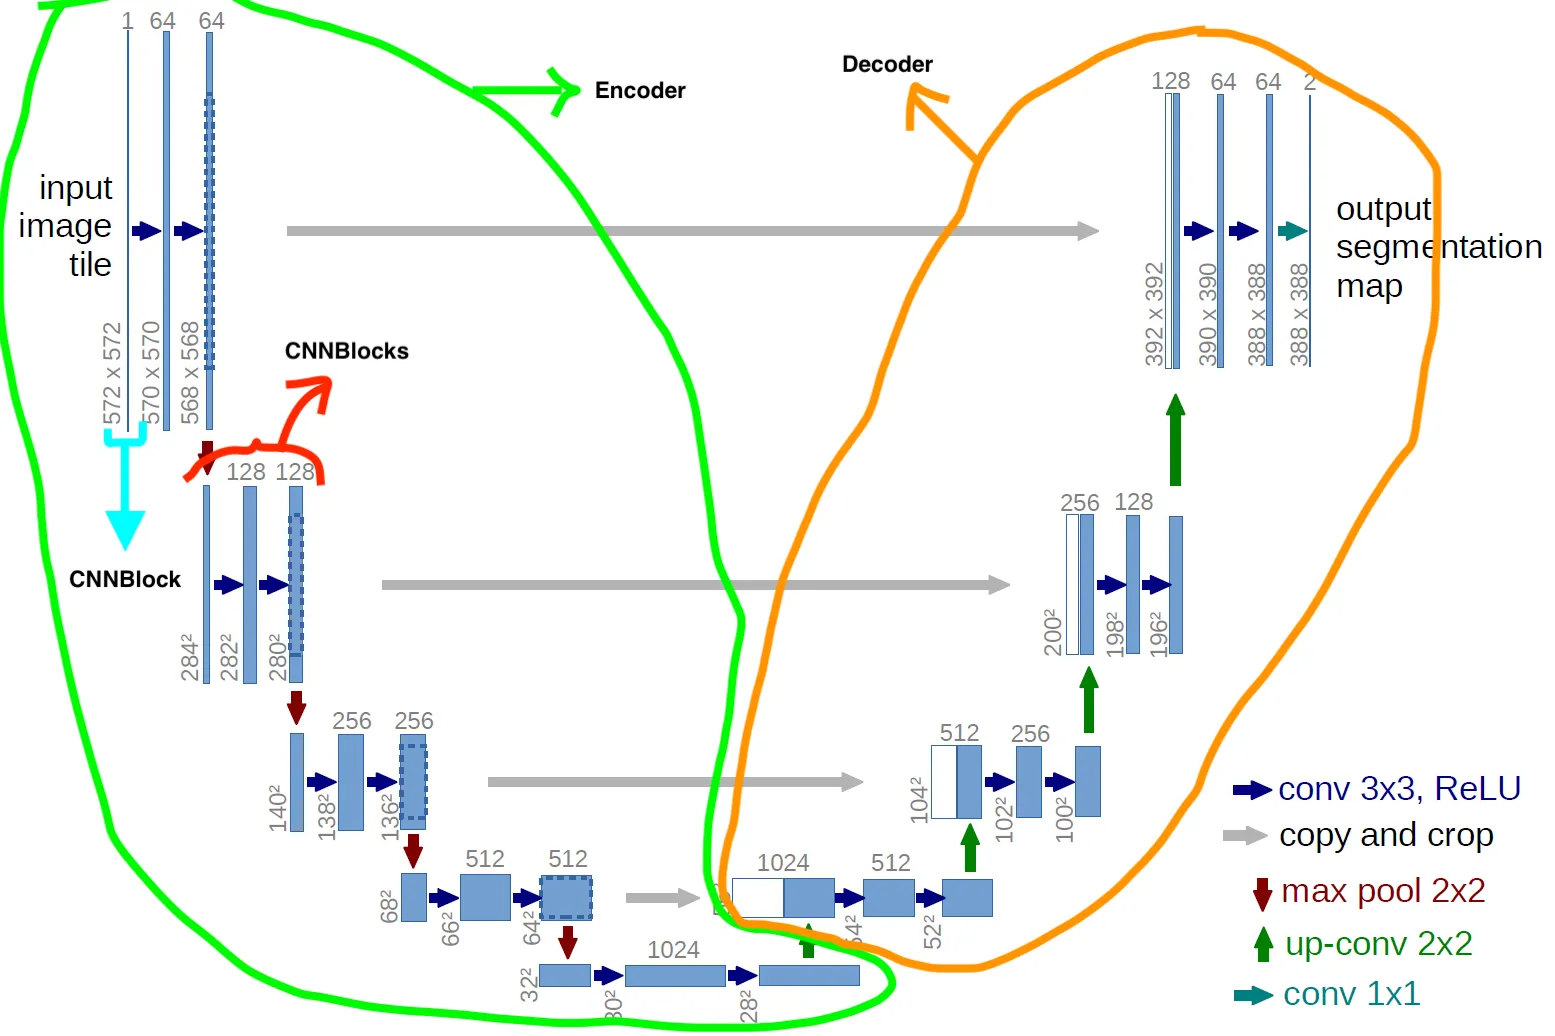

image credit: https://medium.com/mlearning-ai/semantic-segmentation-with-pytorch-u-net-from-scratch-502d6565910a


In [14]:
# https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [21]:
from torchsummary import summary

model=UNet(n_class=1)
#print(model)
summary(model=UNet(n_class=1), input_size=(3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
            Conv2d-5        [-1, 128, 112, 112]         147,584
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
            Conv2d-8          [-1, 256, 56, 56]         590,080
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
           Conv2d-11          [-1, 512, 28, 28]       2,359,808
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Conv2d-13         [-1, 1024, 14, 14]       4,719,616
           Conv2d-14         [-1, 1024,

architecture of resunet    
reference: https://arxiv.org/pdf/1711.10684.pdf

In [9]:
import torch
import torch.nn as nn

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)

class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)
        
class ResUnet(nn.Module):
    def __init__(self, input_channel, filters=[64, 128, 256, 512]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(input_channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(input_channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)
        x6 = self.up_residual_conv1(x5)
        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)
        x8 = self.up_residual_conv2(x7)
        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)
        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output

In [10]:
from torchsummary import summary

model=ResUnet(input_channel=3)
#print(model)
summary(model=ResUnet(input_channel=3), input_size=(3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
            Conv2d-5         [-1, 64, 224, 224]           1,792
       BatchNorm2d-6         [-1, 64, 224, 224]             128
              ReLU-7         [-1, 64, 224, 224]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
           Conv2d-12        [-1, 128, 112, 112]          73,856
      BatchNorm2d-13        [-1, 128, 112, 112]             256
     ResidualConv-14        [-1, 128, 1

architecture of transformer

reference: https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

![image.png](figures/vit.png)

In [5]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

In [8]:
from torchsummary import summary
#print(model)
summary(model=MyViT((3, 224, 224), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10), input_size=(3,224,224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 49, 8]          24,584
         LayerNorm-2                [-1, 50, 8]              16
            Linear-3                    [-1, 4]              20
            Linear-4                    [-1, 4]              20
            Linear-5                    [-1, 4]              20
           Softmax-6                   [-1, 50]               0
            Linear-7                    [-1, 4]              20
            Linear-8                    [-1, 4]              20
            Linear-9                    [-1, 4]              20
          Softmax-10                   [-1, 50]               0
           Linear-11                    [-1, 4]              20
           Linear-12                    [-1, 4]              20
           Linear-13                    [-1, 4]              20
          Softmax-14                   

architecture of transunet

![transunet](figures/transunet.png)

reference: https://github.com/mkara44/transunet_pytorch

In [1]:
import torch
import torch.nn as nn
import numpy as np
from einops import rearrange, repeat


class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_num):
        super().__init__()

        self.head_num = head_num
        self.dk = (embedding_dim // head_num) ** (1 / 2)

        self.qkv_layer = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.out_attention = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x, mask=None):
        qkv = self.qkv_layer(x)

        query, key, value = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.head_num))
        energy = torch.einsum("... i d , ... j d -> ... i j", query, key) * self.dk

        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)

        attention = torch.softmax(energy, dim=-1)

        x = torch.einsum("... i j , ... j d -> ... i d", attention, value)

        x = rearrange(x, "b h t d -> b t (h d)")
        x = self.out_attention(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.mlp_layers(x)

        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(embedding_dim, head_num)
        self.mlp = MLP(embedding_dim, mlp_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        _x = self.multi_head_attention(x)
        _x = self.dropout(_x)
        x = x + _x
        x = self.layer_norm1(x)

        _x = self.mlp(x)
        x = x + _x
        x = self.layer_norm2(x)

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim, block_num=12):
        super().__init__()

        self.layer_blocks = nn.ModuleList(
            [TransformerEncoderBlock(embedding_dim, head_num, mlp_dim) for _ in range(block_num)])

    def forward(self, x):
        for layer_block in self.layer_blocks:
            x = layer_block(x)

        return x


class ViT(nn.Module):
    def __init__(self, img_dim, in_channels, embedding_dim, head_num, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=1):
        super().__init__()

        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)

        self.projection = nn.Linear(self.token_dim, embedding_dim)
        self.embedding = nn.Parameter(torch.rand(self.num_tokens + 1, embedding_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.dropout = nn.Dropout(0.1)

        self.transformer = TransformerEncoder(embedding_dim, head_num, mlp_dim, block_num)

        if self.classification:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        img_patches = rearrange(x,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)

        batch_size, tokens, _ = img_patches.shape

        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...',
                       batch_size=batch_size)

        patches = torch.cat([token, project], dim=1)
        patches += self.embedding[:tokens + 1, :]

        x = self.dropout(patches)
        x = self.transformer(x)
        x = self.mlp_head(x[:, 0, :]) if self.classification else x[:, 1:, :]

        return x


if __name__ == '__main__':
    vit = ViT(img_dim=128,
              in_channels=3,
              patch_dim=16,
              embedding_dim=512,
              block_num=6,
              head_num=4,
              mlp_dim=1024)
    print(sum(p.numel() for p in vit.parameters()))
    print(vit(torch.rand(1, 3, 128, 128)).shape)

13032449
torch.Size([1, 1])


In [3]:
import torch
import torch.nn as nn
from einops import rearrange

class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        width = int(out_channels * (base_width / 64))

        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=2, groups=1, padding=1, dilation=1, bias=False)
        self.norm2 = nn.BatchNorm2d(width)

        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_down = self.downsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = x + x_down
        x = self.relu(x)

        return x


class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_concat=None):
        x = self.upsample(x)

        if x_concat is not None:
            x = torch.cat([x_concat, x], dim=1)

        x = self.layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
        self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
        self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)

        self.vit_img_dim = img_dim // patch_dim
        self.vit = ViT(self.vit_img_dim, out_channels * 8, out_channels * 8,
                       head_num, mlp_dim, block_num, patch_dim=1, classification=False)

        self.conv2 = nn.Conv2d(out_channels * 8, 512, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x1 = self.relu(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x = self.encoder3(x3)

        x = self.vit(x)
        x = rearrange(x, "b (x y) c -> b c x y", x=self.vit_img_dim, y=self.vit_img_dim)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        return x, x1, x2, x3


class Decoder(nn.Module):
    def __init__(self, out_channels, class_num):
        super().__init__()

        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(int(out_channels * 1 / 2), int(out_channels * 1 / 8))

        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), class_num, kernel_size=1)

    def forward(self, x, x1, x2, x3):
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)

        return x


class TransUNet(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim, class_num):
        super().__init__()

        self.encoder = Encoder(img_dim, in_channels, out_channels,
                               head_num, mlp_dim, block_num, patch_dim)

        self.decoder = Decoder(out_channels, class_num)

    def forward(self, x):
        x, x1, x2, x3 = self.encoder(x)
        x = self.decoder(x, x1, x2, x3)

        return x


if __name__ == '__main__':

    transunet = TransUNet(img_dim=128,
                          in_channels=3,
                          out_channels=128,
                          head_num=4,
                          mlp_dim=512,
                          block_num=8,
                          patch_dim=16,
                          class_num=1)

    print(sum(p.numel() for p in transunet.parameters()))
    print(transunet(torch.randn(1, 3, 128, 128)).shape)

66882673
torch.Size([1, 1, 128, 128])


### 3D Neural networks

V-Net

![vnet](./figures/vnet.png)

reference: https://arxiv.org/abs/1606.04797

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch
# reference: https://github.com/Dootmaan/VNet.PyTorch
class conv3d(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        + Instantiate modules: conv-relu-norm
        + Assign them as member variables
        """
        super(conv3d, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=5, padding=2)
        self.relu = nn.PReLU()
        # with learnable parameters
        self.norm = nn.InstanceNorm3d(out_channels, affine=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


class conv3d_x3(nn.Module):
    """Three serial convs with a residual connection.
    Structure:
        inputs --> ① --> ② --> ③ --> outputs
                   ↓ --> add--> ↑
    """

    def __init__(self, in_channels, out_channels):
        super(conv3d_x3, self).__init__()
        self.conv_1 = conv3d(in_channels, out_channels)
        self.conv_2 = conv3d(out_channels, out_channels)
        self.conv_3 = conv3d(out_channels, out_channels)
        self.skip_connection=nn.Conv3d(in_channels,out_channels,1)

    def forward(self, x):
        z_1 = self.conv_1(x)
        z_3 = self.conv_3(self.conv_2(z_1))
        return z_3 + self.skip_connection(x)

class conv3d_x2(nn.Module):
    """Three serial convs with a residual connection.
    Structure:
        inputs --> ① --> ② --> ③ --> outputs
                   ↓ --> add--> ↑
    """

    def __init__(self, in_channels, out_channels):
        super(conv3d_x2, self).__init__()
        self.conv_1 = conv3d(in_channels, out_channels)
        self.conv_2 = conv3d(out_channels, out_channels)
        self.skip_connection=nn.Conv3d(in_channels,out_channels,1)

    def forward(self, x):
        z_1 = self.conv_1(x)
        z_2 = self.conv_2(z_1)
        return z_2 + self.skip_connection(x)


class conv3d_x1(nn.Module):
    """Three serial convs with a residual connection.
    Structure:
        inputs --> ① --> ② --> ③ --> outputs
                   ↓ --> add--> ↑
    """

    def __init__(self, in_channels, out_channels):
        super(conv3d_x1, self).__init__()
        self.conv_1 = conv3d(in_channels, out_channels)
        self.skip_connection=nn.Conv3d(in_channels,out_channels,1)

    def forward(self, x):
        z_1 = self.conv_1(x)
        return z_1 + self.skip_connection(x)

class deconv3d_x3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(deconv3d_x3, self).__init__()
        self.up = deconv3d_as_up(in_channels, out_channels, 2, 2)
        self.lhs_conv = conv3d(out_channels // 2, out_channels)
        self.conv_x3 = nn.Sequential(
            nn.Conv3d(2*out_channels, out_channels,5,1,2),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels,5,1,2),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels,5,1,2),
            nn.PReLU(),
        )

    def forward(self, lhs, rhs):
        rhs_up = self.up(rhs)
        lhs_conv = self.lhs_conv(lhs)
        rhs_add = torch.cat((rhs_up, lhs_conv),dim=1) 
        return self.conv_x3(rhs_add)+ rhs_up

class deconv3d_x2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(deconv3d_x2, self).__init__()
        self.up = deconv3d_as_up(in_channels, out_channels, 2, 2)
        self.lhs_conv = conv3d(out_channels // 2, out_channels)
        self.conv_x2= nn.Sequential(
            nn.Conv3d(2*out_channels, out_channels,5,1,2),
            nn.PReLU(),
            nn.Conv3d(out_channels, out_channels,5,1,2),
            nn.PReLU(),
        )

    def forward(self, lhs, rhs):
        rhs_up = self.up(rhs)
        lhs_conv = self.lhs_conv(lhs)
        rhs_add = torch.cat((rhs_up, lhs_conv),dim=1) 
        return self.conv_x2(rhs_add)+ rhs_up

class deconv3d_x1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(deconv3d_x1, self).__init__()
        self.up = deconv3d_as_up(in_channels, out_channels, 2, 2)
        self.lhs_conv = conv3d(out_channels // 2, out_channels)
        self.conv_x1 = nn.Sequential(
            nn.Conv3d(2*out_channels, out_channels,5,1,2),
            nn.PReLU(),
        )

    def forward(self, lhs, rhs):
        rhs_up = self.up(rhs)
        lhs_conv = self.lhs_conv(lhs)
        rhs_add = torch.cat((rhs_up, lhs_conv),dim=1) 
        return self.conv_x1(rhs_add)+ rhs_up
        

def conv3d_as_pool(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding=0),
        nn.PReLU())


def deconv3d_as_up(in_channels, out_channels, kernel_size=2, stride=2):
    return nn.Sequential(
        nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride),
        nn.PReLU()
    )


class softmax_out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(softmax_out, self).__init__()
        self.conv_1 = nn.Conv3d(in_channels, out_channels, kernel_size=5, padding=2)
        self.conv_2 = nn.Conv3d(out_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        """Output with shape [batch_size, 1, depth, height, width]."""
        # Do NOT add normalize layer, or its values vanish.
        y_conv = self.conv_2(self.conv_1(x))
        return nn.Sigmoid()(y_conv)


class VNet(nn.Module):
    def __init__(self):
        super(VNet, self).__init__()
        self.conv_1 = conv3d_x1(1, 16)
        self.pool_1 = conv3d_as_pool(16, 32)
        self.conv_2 = conv3d_x2(32, 32)
        self.pool_2 = conv3d_as_pool(32, 64)
        self.conv_3 = conv3d_x3(64, 64)
        self.pool_3 = conv3d_as_pool(64, 128)
        self.conv_4 = conv3d_x3(128, 128)
        self.pool_4 = conv3d_as_pool(128, 256)

        self.bottom = conv3d_x3(256, 256)

        self.deconv_4 = deconv3d_x3(256, 256)
        self.deconv_3 = deconv3d_x3(256, 128)
        self.deconv_2 = deconv3d_x2(128, 64)
        self.deconv_1 = deconv3d_x1(64, 32)

        self.out = softmax_out(32, 1)

    def forward(self, x):
        conv_1 = self.conv_1(x)
        pool = self.pool_1(conv_1)
        conv_2 = self.conv_2(pool)
        pool = self.pool_2(conv_2)
        conv_3 = self.conv_3(pool)
        pool = self.pool_3(conv_3)
        conv_4 = self.conv_4(pool)
        pool = self.pool_4(conv_4)
        bottom = self.bottom(pool)
        deconv = self.deconv_4(conv_4, bottom)
        deconv = self.deconv_3(conv_3, deconv)
        deconv = self.deconv_2(conv_2, deconv)
        deconv = self.deconv_1(conv_1, deconv)
        return self.out(deconv)

In [21]:
from torchsummary import summary

summary(model = VNet() , input_size=(1,64,64,64), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 16, 64, 64, 64]           2,016
    InstanceNorm3d-2       [-1, 16, 64, 64, 64]              32
             PReLU-3       [-1, 16, 64, 64, 64]               1
            conv3d-4       [-1, 16, 64, 64, 64]               0
            Conv3d-5       [-1, 16, 64, 64, 64]              32
         conv3d_x1-6       [-1, 16, 64, 64, 64]               0
            Conv3d-7       [-1, 32, 32, 32, 32]           4,128
             PReLU-8       [-1, 32, 32, 32, 32]               1
            Conv3d-9       [-1, 32, 32, 32, 32]         128,032
   InstanceNorm3d-10       [-1, 32, 32, 32, 32]              64
            PReLU-11       [-1, 32, 32, 32, 32]               1
           conv3d-12       [-1, 32, 32, 32, 32]               0
           Conv3d-13       [-1, 32, 32, 32, 32]         128,032
   InstanceNorm3d-14       [-1, 32, 32,

3DU-Net

In [2]:
import torch
from torch import nn
from torchsummary import summary
import time


class Conv3DBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(Conv3DBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels= in_channels, out_channels=out_channels//2, kernel_size=(3,3,3), padding=1)
        nn.init.kaiming_uniform_(self.conv1.weight)
        self.bn1 = nn.BatchNorm3d(num_features=out_channels//2)
        self.conv2 = nn.Conv3d(in_channels= out_channels//2, out_channels=out_channels, kernel_size=(3,3,3), padding=1)
        nn.init.kaiming_uniform_(self.conv2.weight)
        self.bn2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.pooling = nn.MaxPool3d(kernel_size=(2,2,2), stride=2)

    
    def forward(self, input):
        res = self.relu(self.bn1(self.conv1(input)))
        res = self.relu(self.bn2(self.conv2(res)))
        res = self.relu(self.conv1(input))
        res = self.relu(self.conv2(res))
        res = self.dropout(res)
        out = self.pooling(res)
        return out


class DecoderBlock(nn.Module):
 
    def __init__(self, in_channels, mid_channels, out_channels, upsample_mode='deconv', BN_enable=True):
        super().__init__()
        self.in_channels = in_channels
        self.mid_channels = mid_channels
        self.out_channels = out_channels
        self.upsample_mode = upsample_mode
        self.BN_enable = BN_enable
    
        self.conv = nn.Conv3d(in_channels=in_channels, out_channels=mid_channels, kernel_size=3, stride=1, padding=1, bias=False)

        if self.BN_enable: self.norm1 = nn.BatchNorm3d(mid_channels)
        self.relu1 = nn.ReLU(inplace=False)
        self.relu2 = nn.ReLU(inplace=False)

        if self.upsample_mode=='deconv':
            self.upsample = nn.ConvTranspose3d(in_channels=mid_channels, out_channels = out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        elif self.upsample_mode=='pixelshuffle':
            self.upsample = nn.PixelShuffle(upscale_factor=2)
        if self.BN_enable: self.norm2 = nn.BatchNorm3d(out_channels)

    def forward(self,x):
        x=self.conv(x)
        if self.BN_enable: x=self.norm1(x)
        x=self.relu1(x)
        x=self.upsample(x)
        if self.BN_enable: x=self.norm2(x)
        x=self.relu2(x)
        return x



class UNet3D(nn.Module):
    
    def __init__(self, in_channels=2, BN_enable=True):
        super(UNet3D, self).__init__()
        self.BN_enable = BN_enable
        filters=[64, 128, 256, 512, 1024]
        # encoder
        self.encoder0 = Conv3DBlock(in_channels=in_channels, out_channels=filters[0])
        self.encoder1 = Conv3DBlock(in_channels=filters[0], out_channels=filters[1])
        self.encoder2 = Conv3DBlock(in_channels=filters[1], out_channels=filters[2])
        self.encoder3 = Conv3DBlock(in_channels=filters[2], out_channels=filters[3])
        self.encoder4 = Conv3DBlock(in_channels=filters[3], out_channels=filters[4])

        # decoder
        self.decoder4 = DecoderBlock(in_channels=filters[4], mid_channels=filters[4]*4, out_channels=filters[4], BN_enable=self.BN_enable)
        self.decoder3 = DecoderBlock(in_channels=filters[4]+filters[3], mid_channels=filters[3]*4, out_channels=filters[3], BN_enable=self.BN_enable)
        self.decoder2 = DecoderBlock(in_channels=filters[3]+filters[2], mid_channels=filters[2]*4, out_channels=filters[2], BN_enable=self.BN_enable)
        self.decoder1 = DecoderBlock(in_channels=filters[2]+filters[1], mid_channels=filters[1]*4, out_channels=filters[1], BN_enable=self.BN_enable)
        self.decoder0 = DecoderBlock(in_channels=filters[1]+filters[0], mid_channels=filters[0]*4, out_channels=filters[0], BN_enable=self.BN_enable)
        
        if self.BN_enable:
            self.final = nn.Sequential(
                nn.Conv3d(in_channels=filters[0],out_channels=32, kernel_size=3, padding=1),
                nn.BatchNorm3d(32), 
                nn.ReLU(inplace=False),
                nn.Conv3d(in_channels=32, out_channels=1, kernel_size=1),
                )
        else:
            self.final = nn.Sequential(
                nn.Conv3d(in_channels=filters[0],out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(inplace=False),
                nn.Conv3d(in_channels=32, out_channels=1, kernel_size=1), 
                )
     
    def forward(self, input):
        e0 = self.encoder0(input)
        e1 = self.encoder1(e0)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)

        e4 = self.encoder4(e3) # bottleneck
        d4 = self.decoder4(e4) # bottleneck
        
        d3 = self.decoder3(torch.cat([d4,e3], dim=1))
        d2 = self.decoder2(torch.cat([d3,e2], dim=1))
        d1 = self.decoder1(torch.cat([d2,e1], dim=1))
        d0 = self.decoder0(torch.cat([d1,e0], dim=1))
        return self.final(d0)


if __name__ == '__main__':
    model = UNet3D()
    start_time = time.time()
    summary(model=model, input_size=(2,64, 64, 64), batch_size=-1, device="cpu")
    print("--- %.4s seconds ---" % (time.time() - start_time))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 64, 64, 64]           1,760
       BatchNorm3d-2       [-1, 32, 64, 64, 64]              64
              ReLU-3       [-1, 32, 64, 64, 64]               0
            Conv3d-4       [-1, 64, 64, 64, 64]          55,360
       BatchNorm3d-5       [-1, 64, 64, 64, 64]             128
              ReLU-6       [-1, 64, 64, 64, 64]               0
            Conv3d-7       [-1, 32, 64, 64, 64]           1,760
              ReLU-8       [-1, 32, 64, 64, 64]               0
            Conv3d-9       [-1, 64, 64, 64, 64]          55,360
             ReLU-10       [-1, 64, 64, 64, 64]               0
          Dropout-11       [-1, 64, 64, 64, 64]               0
        MaxPool3d-12       [-1, 64, 32, 32, 32]               0
      Conv3DBlock-13       [-1, 64, 32, 32, 32]               0
           Conv3d-14       [-1, 64, 32,

### Utilize

visualize a model

In [ ]:
# visualize a model method 1
'''
install graphviz.exe + torchviz
如果你的电脑还是无法画图,并且出现了下面的报错:
CalledProcessError: Command '['dot', '-Tpdf', '-O', iitH.gv']' returned non-zero exit status 1. [st
那么我们这个时候就可以按照下面步骤完成画图:
1.打开cmd(使用管理员身份,要不然没有权限)
2.运行:dot-v
3.出现问题:There is no layout engine support for "dot" ...
4.运行:dot-c
5.没有提示(成功)
6.再次运行dot-v
7.结果就会画图成功
'''
from torchviz import make_dot, make_dot_from_trace
from torchvision.models import AlexNet
model = ResUnet(input_channel=3)

x = torch.randn(1, 3, 224, 224).requires_grad_(True)
y = model(x)
make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
#g = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
#g.view()  # 直接在当前路径下保存 pdf 并打开
# g.render(filename='netStructure/myNetModel', view=False, format='pdf')  # 保存 pdf 到指定路径不打开

In [19]:
# visualize a model method 2
from torchvision.models import AlexNet
import netron
import torch.onnx

model = ResUnet(input_channel=3)

x = torch.randn(1,3, 224, 224).requires_grad_(True)
y = model(x)

modelData = "./demo.pth"  # 定义模型数据保存的路径
torch.onnx.export(model, x, modelData)  # 将 pytorch 模型以 onnx 格式导出并保存
netron.start(modelData)  # 输出网络结构

#  针对已经存在网络模型 .pth 文件的情况
#modelData = "./demo.pth"  # 定义模型数据保存的路径
#netron.start(modelData)  # 输出网络结构

Serving './demo.pth' at http://localhost:8080


('localhost', 8080)

data loader

In [ ]:
# load data
import torch

# 定义数据集类
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)

# 加载数据
data = torch.randn(100, 10)
labels = torch.randint(0, 10, (100,))

# 创建数据集
dataset = MyDataset(data, labels)

# 加载数据
loader = torch.utils.data.DataLoader(dataset, batch_size=128)

# 迭代加载器
for images, labels in loader:
    print(images.size())
    print(labels.size())


interatcitve selection

In [32]:
import ipywidgets as widgets
from IPython.display import display

# 创建下拉菜单
model_type = widgets.Dropdown(
    options=['mar_base', 'mar_large', 'mar_huge'],
    value='mar_large',  # 默认选择值
    description='Model Type:',
)

# 显示下拉菜单
display(model_type)

# 定义一个更新函数，用来打印更新后的值
def on_change(change):
    print(f"Selected model: {model_type.value}")

# 当用户更改下拉菜单的选项时触发更新
model_type.observe(on_change, names='value')

# 定义另一个函数，用于后续使用model_type
def use_model_type():
    return model_type.value


Dropdown(description='Model Type:', index=1, options=('mar_base', 'mar_large', 'mar_huge'), value='mar_large')

Selected model: mar_base
Selected model: mar_huge


In [34]:
# 调用函数以显示当前选择的模型类型
use_model_type()

'mar_huge'

### Self Supervised Learning
refercence:https://github.com/lightly-ai/lightly?tab=readme-ov-file    
 https://docs.lightly.ai/self-supervised-learning/index.html

In [45]:
import torchvision
import torch
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform
from lightly.data import LightlyDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# The following transform will return two augmented images per input image.
transform = SimCLRTransform()

# Create a dataset from your image folder.
dataset = LightlyDataset(
    input_dir='/wholebody_2D/ct/',
    transform=transform,
)

# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,                # Pass the dataset to the dataloader.
    batch_size=128,         # A large batch size helps with learning.
    shuffle=True,           # Shuffling is important!
)

# use a resnet backbone
resnet = torchvision.models.resnet18()
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

# build a SimCLR model
class SimCLR(torch.nn.Module):
    def __init__(self, backbone, hidden_dim, out_dim):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, out_dim)

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

model = SimCLR(resnet, hidden_dim=512, out_dim=128).to(device)

# use a criterion for self-supervised learning
# (normalized temperature-scaled cross entropy loss)
criterion = NTXentLoss(temperature=0.5)

# get a PyTorch optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-5)

max_epochs = 10
for epoch in range(max_epochs):
    for (x0, x1), _, _ in dataloader:

        x0 = x0.to(device)
        x1 = x1.to(device)

        z0 = model(x0)
        z1 = model(x1)

        loss = criterion(z0, z1)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    print(f"loss: {loss.item():.5f}")

loss: 5.42013
loss: 5.51289
loss: 5.45845
loss: 5.45596
loss: 5.40158
loss: 5.40549
loss: 5.41606
loss: 5.42258
loss: 5.51112
loss: 5.36894


### Keras 3
The full Keras API, available for JAX, TensorFlow, and PyTorch.    
https://keras.io/examples/

In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras

print(keras.__version__)

3.5.0


MNIST convnet

In [5]:
import numpy as np
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000,)
60000 train samples
10000 test samples


In [7]:
# Model parameters
num_classes = 10
input_shape = (28, 28, 1)

model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,298 (1016.79 KB)

 Trainable params: 260,298 (1016.79 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],
)

batch_size = 128
epochs = 10

callbacks = [
    #keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)
score = model.evaluate(x_test, y_test, verbose=0)
model.save("final_model.keras")
model = keras.saving.load_model("final_model.keras")
predictions = model.predict(x_test)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - acc: 0.9882 - loss: 0.0414 - val_acc: 0.9932 - val_loss: 0.0273
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - acc: 0.9881 - loss: 0.0381 - val_acc: 0.9933 - val_loss: 0.0240
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - acc: 0.9883 - loss: 0.0382 - val_acc: 0.9941 - val_loss: 0.0288
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - acc: 0.9902 - loss: 0.0331 - val_acc: 0.9927 - val_loss: 0.0280
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


An complete customized example

In [3]:
import os

# This guide can only be run with the torch backend.
os.environ["KERAS_BACKEND"] = "torch"

import torch
import keras
from keras import layers
import numpy as np

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(7 * 7 * 128),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)


class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_tracker = keras.metrics.Mean(name="d_loss")
        self.g_loss_tracker = keras.metrics.Mean(name="g_loss")
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.built = True

    @property
    def metrics(self):
        return [self.d_loss_tracker, self.g_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        if isinstance(real_images, tuple) or isinstance(real_images, list):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = real_images.shape[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        real_images = torch.tensor(real_images, device=device)
        combined_images = torch.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = torch.concat(
            [
                torch.ones((batch_size, 1), device=device),
                torch.zeros((batch_size, 1), device=device),
            ],
            axis=0,
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * keras.random.uniform(labels.shape, seed=self.seed_generator)

        # Train the discriminator
        self.zero_grad()
        predictions = self.discriminator(combined_images)
        d_loss = self.loss_fn(labels, predictions)
        d_loss.backward()
        grads = [v.value.grad for v in self.discriminator.trainable_weights]
        with torch.no_grad():
            self.d_optimizer.apply(grads, self.discriminator.trainable_weights)

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = torch.zeros((batch_size, 1), device=device)

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        self.zero_grad()
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.loss_fn(misleading_labels, predictions)
        grads = g_loss.backward()
        grads = [v.value.grad for v in self.generator.trainable_weights]
        with torch.no_grad():
            self.g_optimizer.apply(grads, self.generator.trainable_weights)

        # Update metrics and return their value.
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)
        return {
            "d_loss": self.d_loss_tracker.result(),
            "g_loss": self.g_loss_tracker.result(),
        }

# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

# Create a TensorDataset
dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(all_digits), torch.from_numpy(all_digits)
)
# Create a DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(dataloader, epochs=1)

C:\Users\zhang\AppData\Local\Temp\ipykernel_48840\834262769.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_images = torch.tensor(real_images, device=device)


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step - d_loss: 0.4536 - g_loss: 1.2440
